# CS760 HW2 CODE
**Author: Jiahui Zhang**

In [1]:
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import re

root = 'D:\\LIFE\\WORK\\5-Doctorate\\Coursework\\CS 760\\hw_CS760\\CS760_HW2\\'

In [94]:
def read_data(file):
    '''
    Read in given data [X in 2D real-valued space, Y is binary (0,1)]
    '''
    y = []
    x = []
    with open(file, 'r') as f:
        for line in f:
            line = line.replace('\n','').split(' ')
            x1, x2, current_y = float(line[0]), float(line[1]), int(line[2])
            assert current_y in [0,1]
            x.append([x1,x2])
            y.append(current_y)
    y = np.array(y)
    x = np.array(x)
    return x,y

In [95]:
def cal_entropy(sub_y):
    '''
    Calculate the entropy value of given subset of samples
    '''
    n = len(sub_y)
    ctr = Counter(sub_y)
    if len(ctr) < 2: # all y are the same
        return 0
    p_pos = ctr[1] / n
    p_neg = ctr[0] / n
    res = - p_pos*np.log(p_pos)/np.log(2) - p_neg*np.log(p_neg)/np.log(2)
    return res
    
def splitter(sub_x,sub_y):
    '''
    Given a subset of samples, find the best split according to info-gain
    '''
    n, p = sub_x.shape
    assert len(sub_y) == n
    current_entropy = cal_entropy(sub_y)
    #print("Initial entro:",current_entropy)
    if current_entropy == 0:
        #print("Stop splitting in this branch (homogeneous)")
        return [-1,None]
    max_info_gain_ratio = 0
    best_decision = [-1,None] # first is splitting dimension, second is threshold
    for dim in range(p):
        for c in sub_x[:,dim]:
            left_indices = [i for i in range(n) if sub_x[i,dim] >= c]
            right_indices = [i for i in range(n) if sub_x[i,dim] < c]
            left_entropy = cal_entropy(sub_y[left_indices])
            right_entropy = cal_entropy(sub_y[right_indices])
            current_info_gain = current_entropy - len(left_indices)/n*left_entropy - len(right_indices)/n*right_entropy
            split_y = np.concatenate((np.ones(len(left_indices)),np.zeros(len(right_indices))),axis=None)
            current_split_entropy = cal_entropy(split_y)
            if current_split_entropy == 0:
                continue
            current_info_gain_ratio = current_info_gain / current_split_entropy
            if current_info_gain_ratio > max_info_gain_ratio:
                best_decision = [dim,c]
                max_info_gain_ratio = current_info_gain_ratio
    #if best_decision[0] == -1:
    #    print("Stop splitting in this branch (no info-gain)")
    #else:
    #    print('Best decision:',best_decision,'Info-gain ratio:',max_info_gain_ratio)
    return best_decision

def DT_learner(x,y,action_trace='',log_save_file=root):
    '''
    Main function of DT learning. 
    Output a text file log recording how to split and predict in `log_save_file`. 
    '''
    n, p = x.shape
    assert len(y) == n
    current_decision = splitter(x,y)
    dim, c = current_decision
    if dim == -1:
        ctr = Counter(y)
        current_predict = sorted(ctr.items(),key=lambda x:x[1])[0][0]
        if len(ctr) == 2 and ctr[0] == ctr[1]:
            current_predict = 1 # if no majority, predict y=1
        print(action_trace + '=(PRED:%d)'%current_predict)
        with open(log_save_file,'a+') as f:
            f.write(str(action_trace) + '=(PRED:%d)'%current_predict + '\n')
        return 
    else:
        left_indices = [i for i in range(n) if x[i,dim] >= c]
        right_indices = [i for i in range(n) if x[i,dim] < c]
        current_instruction = '=(SPLIT:%d,%s)'%(dim,str(c))
        DT_learner(x[left_indices,:],y[left_indices],action_trace+current_instruction+'[LEFT]',log_save_file=log_save_file)
        DT_learner(x[right_indices,:],y[right_indices],action_trace+current_instruction+'[RIGHT]',log_save_file=log_save_file)
        return 


In [96]:
x,y = read_data(file=root+'data\\D1.txt')
DT_learner(x,y,log_save_file=root+'D1results.txt')

=(SPLIT:1,0.201829)[LEFT]=(PRED:1)
=(SPLIT:1,0.201829)[RIGHT]=(PRED:0)


In [97]:
def plotter(x,y,log_save_file,original_data=True):
    plt.figure()
    xmin, xmax = np.min(x[:,0]), np.max(x[:,0])
    ymin, ymax = np.min(x[:,1]), np.max(x[:,1])
    lines_to_plot = [] # each element in the form (x1,x2,y1,y2)
    with open(log_save_file,'r') as f:
        for line in f:
            line = line.replace('\n','').split('=')[1:-1]
            local_xmin, local_xmax = xmin,xmax
            local_ymin, local_ymax = ymin,ymax
            for i in range(len(line)):
                matchobj = re.match(r'\(SPLIT:(.*?),(.*?)\)\[(.*?)\]',line[i])
                p, c, direction = int(matchobj.group(1)), float(matchobj.group(2)), matchobj.group(3)
                if p == 0: # split according to x
                    line_to_plot = (c,c,local_ymin,local_ymax)
                    if direction == 'LEFT':
                        local_xmin = c
                    else:
                        local_xmax = c
                elif p == 1:
                    line_to_plot = (local_xmin,local_xmax,c,c)
                    if direction == 'LEFT':
                        local_ymin = c
                    else:
                        local_ymax = c
                if line_to_plot not in lines_to_plot:
                    lines_to_plot.append(line_to_plot)
    for line in lines_to_plot:
        x1,x2,y1,y2 = line
        plt.plot([x1,x2], [y1,y2], color='black')
    
    fake_x = np.linspace(xmin,xmax,100)
    fake_y = np.linspace(ymin,ymax,100)
    xs0 = []
    ys0 = []
    xs1 = []
    ys1 = []
    for xxx in fake_x:
        for yyy in fake_y:
            outflag = 0
            with open(log_save_file,'r') as f:
                for line in f:
                    if outflag == 1:
                        break
                    rules = line.replace('\n','').split('=')[1:-1]
                    predval = int(line.replace('\n','').split('=')[-1][-2])
                    for i in range(len(rules)):
                        matchobj = re.match(r'\(SPLIT:(.*?),(.*?)\)\[(.*?)\]',rules[i])
                        p, c, direction = int(matchobj.group(1)), float(matchobj.group(2)), matchobj.group(3)
                        if p == 0:
                            if (xxx >= c and direction == 'LEFT') or (xxx < c and direction == 'RIGHT'):
                                if i == len(rules)-1:
                                    outflag = 1
                                    if predval == 0:
                                        xs0.append(xxx)
                                        ys0.append(yyy)
                                    else:
                                        xs1.append(xxx)
                                        ys1.append(yyy)
                                continue
                            else:
                                break
                        elif p == 1:
                            if (yyy >= c and direction == 'LEFT') or (yyy < c and direction == 'RIGHT'):
                                if i == len(rules)-1:
                                    outflag = 1
                                    if predval == 0:
                                        xs0.append(xxx)
                                        ys0.append(yyy)
                                    else:
                                        xs1.append(xxx)
                                        ys1.append(yyy)
                                continue
                            else:
                                break
    
    plt.scatter(xs0,ys0,c='salmon',s=12)
    plt.scatter(xs1,ys1,c='lightblue',s=12)
    if original_data:
        plt.scatter(x[:,0],x[:,1],c=y,s=10)
    plt.show()

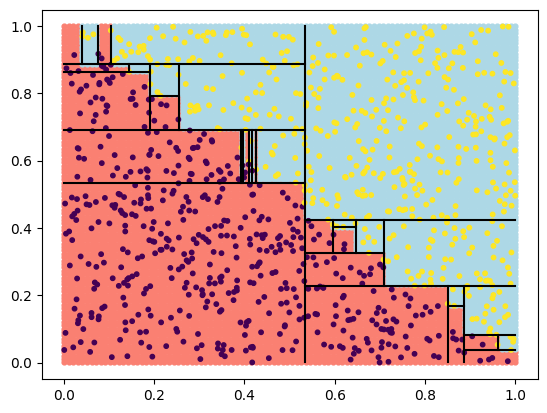

In [98]:
x,y = read_data(file=root+'data\\D2.txt')
plotter(x,y,log_save_file=root+'D2results.txt')

In [99]:
# permutate and split data
x,y = read_data(file=root+'data\\Dbig.txt')
np.random.seed(2023) # fix the results to make it reproduceable 
index_permutation = np.random.choice(range(10000),size=10000,replace=False)
x32, y32 = x[index_permutation[:32],:], y[index_permutation[:32]]
x128, y128 = x[index_permutation[:128],:], y[index_permutation[:128]]
x512, y512 = x[index_permutation[:512],:], y[index_permutation[:512]]
x2048, y2048 = x[index_permutation[:2048],:], y[index_permutation[:2048]]
x8192, y8192 = x[index_permutation[:8192],:], y[index_permutation[:8192]]

In [100]:
def DT_tester(x,y,log_save_file):
    preds = []
    for (xxx,yyy) in x:
        outflag = 0
        with open(log_save_file,'r') as f:
            for line in f:
                if outflag == 1:
                    break
                rules = line.replace('\n','').split('=')[1:-1]
                predval = int(line.replace('\n','').split('-')[-1][-2])
                for i in range(len(rules)):
                    matchobj = re.match(r'\(SPLIT:(.*?),(.*?)\)\[(.*?)\]',rules[i])
                    print(rules[i])
                    p, c, direction = int(matchobj.group(1)), float(matchobj.group(2)), matchobj.group(3)
                    if p == 0:
                        if (xxx >= c and direction == 'LEFT') or (xxx < c and direction == 'RIGHT'):
                            if i == len(rules)-1:
                                outflag = 1
                                preds.append(predval)
                            continue
                        else:
                            break
                    elif p == 1:
                        if (yyy >= c and direction == 'LEFT') or (yyy < c and direction == 'RIGHT'):
                            if i == len(rules)-1:
                                outflag = 1
                                preds.append(predval)
                            continue
                        else:
                            break
    error_count = len([i for i in range(len(preds)) if preds[i] != y[i]])
    print("N=%d, error count=%d, error rate=%.4f" % (len(y),error_count,error_count/len(y)))

In [101]:
TRAIN_N = 32
DT_learner(x32,y32,log_save_file=root+'Dbig%dresults.txt'%TRAIN_N)

testx, testy = x[index_permutation[TRAIN_N:],:], y[index_permutation[TRAIN_N:]]
DT_tester(testx,testy,log_save_file=root+'Dbig%dresults.txt'%TRAIN_N)


=(SPLIT:1,-0.805211)[LEFT]=(SPLIT:1,0.923182)[LEFT]=(PRED:1)
=(SPLIT:1,-0.805211)[LEFT]=(SPLIT:1,0.923182)[RIGHT]=(SPLIT:0,-0.838163)[LEFT]=(SPLIT:0,1.272757)[LEFT]=(PRED:1)
=(SPLIT:1,-0.805211)[LEFT]=(SPLIT:1,0.923182)[RIGHT]=(SPLIT:0,-0.838163)[LEFT]=(SPLIT:0,1.272757)[RIGHT]=(PRED:0)
=(SPLIT:1,-0.805211)[LEFT]=(SPLIT:1,0.923182)[RIGHT]=(SPLIT:0,-0.838163)[RIGHT]=(PRED:1)
=(SPLIT:1,-0.805211)[RIGHT]=(PRED:1)
(SPLIT:1,-0.805211)[LEFT]
(SPLIT:1,0.923182)[LEFT]
(SPLIT:1,-0.805211)[LEFT]
(SPLIT:1,0.923182)[LEFT]
(SPLIT:1,-0.805211)[LEFT]
(SPLIT:1,0.923182)[RIGHT]
(SPLIT:0,-0.838163)[LEFT]
(SPLIT:0,1.272757)[LEFT]
(SPLIT:1,-0.805211)[LEFT]
(SPLIT:1,0.923182)[RIGHT]
(SPLIT:0,-0.838163)[LEFT]
(SPLIT:0,1.272757)[RIGHT]
(SPLIT:1,-0.805211)[LEFT]
(SPLIT:1,-0.805211)[LEFT]
(SPLIT:1,-0.805211)[LEFT]
(SPLIT:1,-0.805211)[LEFT]
(SPLIT:1,-0.805211)[RIGHT]
(SPLIT:1,-0.805211)[LEFT]
(SPLIT:1,0.923182)[LEFT]
(SPLIT:1,-0.805211)[LEFT]
(SPLIT:1,0.923182)[RIGHT]
(SPLIT:0,-0.838163)[LEFT]
(SPLIT:0,1.272757

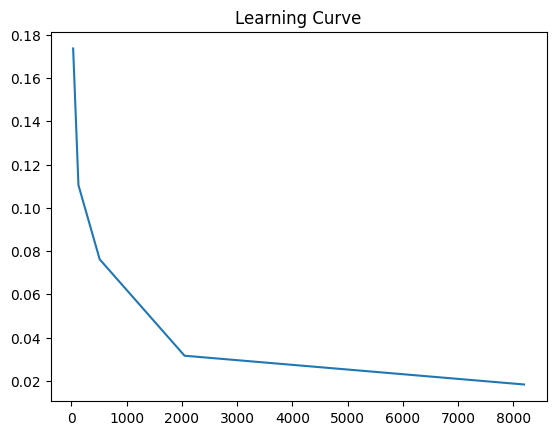

In [102]:
n = [32,128,512,2048,8192]
error_rate = [0.1737,0.1105,0.0762,0.0316,0.0183]
plt.figure()
plt.plot(n,error_rate)
plt.title('Learning Curve')
plt.show()

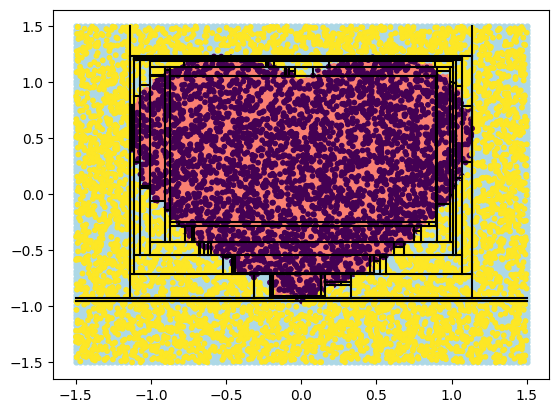

In [103]:
TRAIN_N = 32
plotter(x8192,y8192,log_save_file=root+'Dbig%dresults.txt'%TRAIN_N)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics

clf = DecisionTreeClassifier()
for TRAIN_N in [32,128,512,2048,8192]:
    train_x,train_y = x[index_permutation[:TRAIN_N],:], y[index_permutation[:TRAIN_N]]
    test_x,test_y = x[index_permutation[TRAIN_N:],:], y[index_permutation[TRAIN_N:]]
    clf = clf.fit(train_x,train_y)
    y_pred = clf.predict(test_x)
    print("Error rate of %d:"%TRAIN_N, 1-metrics.accuracy_score(test_y, y_pred))
    print("Number of leaves:",clf.get_n_leaves())


Train error (MSE): 8.413555061784814e-09


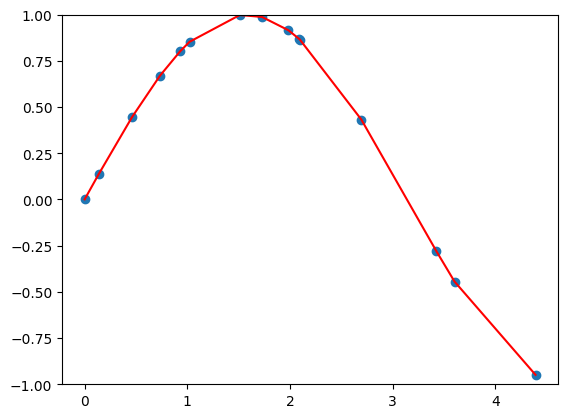

Test error (MSE): 8.320022285989262e-08


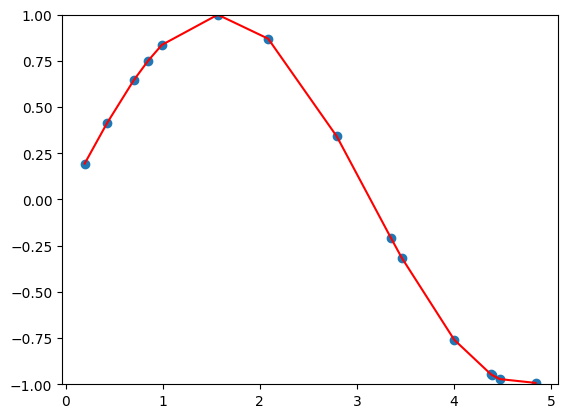

In [3]:
# LAGRANGE
from scipy.interpolate import lagrange
from numpy.polynomial.polynomial import Polynomial

A = 0
B = 5
n = 15
np.random.seed(1)
train_x = np.random.uniform(low=A,high=B,size=n)
train_x = np.array(sorted(train_x))
train_y = np.sin(train_x)
poly = lagrange(train_x,train_y)
pred_y = Polynomial(poly.coef[::-1])(train_x)
print("Train error (MSE):",metrics.mean_squared_error(train_y,pred_y))
plt.figure()
plt.scatter(train_x,train_y)
plt.plot(train_x,pred_y,c='red')
plt.ylim(-1,1)
plt.show()

test_x = np.random.uniform(low=A,high=B,size=n)
test_x = np.array(sorted(test_x))
test_y = np.sin(test_x)
pred_y = Polynomial(poly.coef[::-1])(test_x)
print("Test error (MSE):",metrics.mean_squared_error(test_y,pred_y))
plt.figure()
plt.scatter(test_x,test_y)
plt.plot(test_x,pred_y,c='red')
plt.ylim(-1,1)
plt.show()



Train error (MSE): 1.6467009239905736e-07


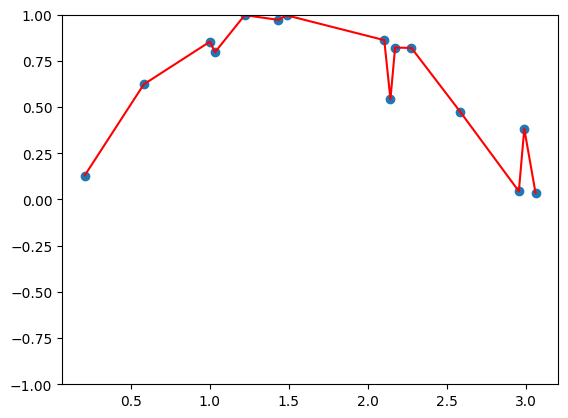

Test error (MSE): 9.37123056504261e+18


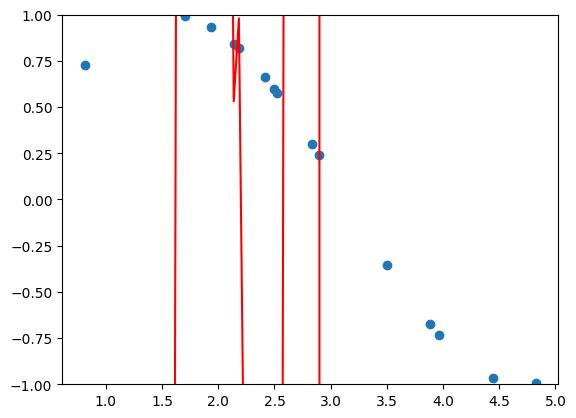

In [4]:
A = 0
B = 5
n = 15
np.random.seed(2)
train_x = np.random.uniform(low=A,high=B,size=n)
noise_x = np.random.randn(n)/5
train_y = np.sin(train_x)
train_x = train_x + noise_x
ind = np.argsort(train_x)
train_x = train_x[ind]
train_y = train_y[ind]
poly = lagrange(train_x,train_y)
pred_y = Polynomial(poly.coef[::-1])(train_x)
print("Train error (MSE):",metrics.mean_squared_error(train_y,pred_y))
plt.figure()
plt.scatter(train_x,train_y)
plt.plot(train_x,pred_y,c='red')
plt.ylim(-1,1)
plt.show()

test_x = np.random.uniform(low=A,high=B,size=n)
test_x = np.array(sorted(test_x))
test_y = np.sin(test_x)
pred_y = Polynomial(poly.coef[::-1])(test_x)
print("Test error (MSE):",metrics.mean_squared_error(test_y,pred_y))
plt.figure()
plt.scatter(test_x,test_y)
plt.plot(test_x,pred_y,c='red')
plt.ylim(-1,1)
plt.show()